# Phase 1: Feasibility Study

I am gonna test if clustering can actually work with simple features

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt

In [3]:
# load data
df = pd.read_csv('../data/processed/full_market_matrix.csv', index_col=0, parse_dates=True)
df.tail()

,AAVE,ADA,ALGO,ATOM,AVAX,BNB,BTC,DOGE,DOT,ETH,...,LINK,LTC,MATIC,SOL,TRX,UNI,VET,XLM,XRP,fg_raw
Date,,,,,,,,,,,,,,,,,,,,,
2025-12-31,146.157852,0.332830,0.110272,1.926895,12.304885,863.257385,87508.828125,0.117294,1.789199,2967.037598,...,12.188008,76.777306,0.216415,124.484467,0.284271,0.000163,0.010411,0.200651,1.839973,21.0
2026-01-01,148.690201,0.356212,0.120008,2.065787,13.549633,863.054626,88731.984375,0.126680,1.996028,3000.394287,...,12.586159,79.843811,0.216415,126.761124,0.286523,0.000163,0.011062,0.208512,1.877936,20.0
2026-01-02,165.010849,0.393758,0.127333,2.164830,13.799940,880.844177,89944.695312,0.141673,2.161198,3124.422607,...,13.263242,81.823280,0.216415,132.133667,0.288772,0.000163,0.011684,0.218848,2.005817,28.0
2026-01-03,163.000946,0.389375,0.127868,2.238555,13.988400,878.639465,90603.187500,0.143058,2.125039,3125.917480,...,13.231463,82.052773,0.216415,133.298477,0.295363,0.000163,0.011707,0.222008,2.017407,29.0
2026-01-04,163.916565,0.400091,0.135829,2.337571,14.227369,894.383667,91413.492188,0.149308,2.139850,3140.710449,...,13.398760,82.133148,0.216415,133.899612,0.293874,0.000163,0.012114,0.232537,2.090021,25.0


## Build a few simple features

In [4]:
# Feature 1: BTC daily return, log return, shifted by 1 day is enough
df['ret_btc'] = np.log(df['BTC'] / df['BTC'].shift(1))

'''
rolling(7): Create 7-day rolling window, looking back 7 days for each day
             Why 7 days? Balance between responsiveness and stability
             - If 3 days: too much noise, overly sensitive to outliers
             - If 30 days: lags behind, can't capture rapid regime shifts
std(): Calculate standard deviation of these 7-day returns (measures volatility) → daily volatility
np.sqrt(365): Annualization using square-root rule → annualized vol = daily vol × √trading days
                Math: Variance is additive → annual variance = daily variance × 365
                      → annual std = √(daily variance × 365) = daily std × √365
                      this is a financial rule
'''
# Feature 2: BTC 7-day volatility (annualized)
df['vol_btc_7'] = df['ret_btc'].rolling(7).std() * np.sqrt(365)

# Feature 3: normalize fear&greed to 0-1
df['fg_norm'] = df['fg_raw'] / 100

print("Features created")
df[['ret_btc', 'vol_btc_7', 'fg_norm']].tail()

df.shape

Features created


(2926, 24)

In [5]:
# remove rows with NA values
df_feat = df[['ret_btc', 'vol_btc_7', 'fg_norm']].dropna()
df_feat.reset_index(inplace=True)  # turn date index to column

print(df_feat.shape)
df_feat.tail()


(2895, 4)


,Date,ret_btc,vol_btc_7,fg_norm
2890,2025-12-31,-0.010473,0.163933,0.21
2891,2026-01-01,0.013881,0.186970,0.20
2892,2026-01-02,0.013575,0.202279,0.28
2893,2026-01-03,0.007294,0.203287,0.29
2894,2026-01-04,0.008904,0.202133,0.25


## Quick test: which k works best?

Before going deeper, let's quickly test a few k values

In [6]:
# Standardize features 
# we must standardize features before clustering validation, because 

from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

scaler = StandardScaler()

# 
X = scaler.fit_transform(df_feat[['ret_btc', 'vol_btc_7', 'fg_norm']])

print(f"Standardized feature matrix shape: {X.shape}")
print(f"Features: ret_btc, vol_btc_7, fg_norm")

Standardized feature matrix shape: (2895, 3)
Features: ret_btc, vol_btc_7, fg_norm


In [ ]:
# test k from 2 to 10
k_values = range(2, 11)
inertias = []
silhouettes = []
db_scores = []

for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X)
    
    inertias.append(km.inertia_)
    silhouettes.append(silhouette_score(X, labels))
    db_scores.append(davies_bouldin_score(X, labels))

print("Testing done")
print("Inertias:", inertias)
print("Silhouette Scores:", silhouettes)
print("Davies-Bouldin Scores:", db_scores)

"""
Clustering Quality Metrics:

1. Inertias (Within-Cluster Sum of Squares):
   - Measures how compact/tight each cluster is
   - Calculation: Sum of squared distances from each point to its cluster center
   - Lower values = tighter clusters
   - Always decreases as k increases (NOT reliable alone for choosing k)
   - Use: Look for "elbow point" where decrease rate slows down

2. Silhouette Scores (Cluster Separation Quality):
   - Measures how well-separated clusters are
   - Range: -1 to 1 (higher is better)
   - Interpretation:
     * >0.5: Strong, well-separated cluster structure
     * 0.25-0.5: Reasonable separation, acceptable clusters
     * <0.25: Weak structure, possibly artificial clusters
   - Calculation: (b - a) / max(a, b)
     where a = avg distance within cluster, b = avg distance to nearest cluster
   - This is the MOST reliable metric for choosing k

3. Davies-Bouldin Index (Compactness vs Separation Ratio):
   - Measures the ratio of within-cluster scatter to between-cluster separation
   - Lower is better (0 = perfect separation)
   - Calculation: Average of max similarity between each cluster and its most similar neighbor
   - Penalizes clusters that are too spread out or too close together
   - Use together with Silhouette for robust k selection
"""


Testing done
Inertias: [6470.783772753461, 5244.943425224417, 4259.082970288405, 3795.1494128351205, 3408.1062891533875, 3069.878278114982, 2833.813911264546, 2574.7013242293197, 2358.1073250849445]
Silhouette Scores: [0.28915097416592866, 0.29664723791859565, 0.3023815558892185, 0.28207436156353394, 0.28585437857975887, 0.2443039814020069, 0.24698063343408516, 0.25982064143360023, 0.2555213653858728]
Davies-Bouldin Scores: [1.4069199685640783, 1.2254325034003, 1.0805036095337166, 1.1084618758233729, 1.0146881028152885, 1.0616209107669758, 1.071339618165162, 1.0403583522464697, 1.00798546649543]


'\nExplanation of Clustering Quality Metrics:\n\n1. Inertias (Within-Cluster Sum of Squares):\n   - Measures how compact/tight each cluster is\n   - Calculation: Sum of squared distances from each point to its cluster center\n   - Lower values = tighter clusters\n   - Always decreases as k increases (NOT reliable alone for choosing k)\n   - Use: Look for "elbow point" where decrease rate slows down\n\n2. Silhouette Scores (Cluster Separation Quality):\n   - Measures how well-separated clusters are\n   - Range: -1 to 1 (higher is better)\n   - Interpretation:\n     * >0.5: Strong, well-separated cluster structure\n     * 0.25-0.5: Reasonable separation, acceptable clusters\n     * <0.25: Weak structure, possibly artificial clusters\n   - Calculation: (b - a) / max(a, b)\n     where a = avg distance within cluster, b = avg distance to nearest cluster\n   - This is the MOST reliable metric for choosing k\n\n3. Davies-Bouldin Index (Compactness vs Separation Ratio):\n   - Measures the rati

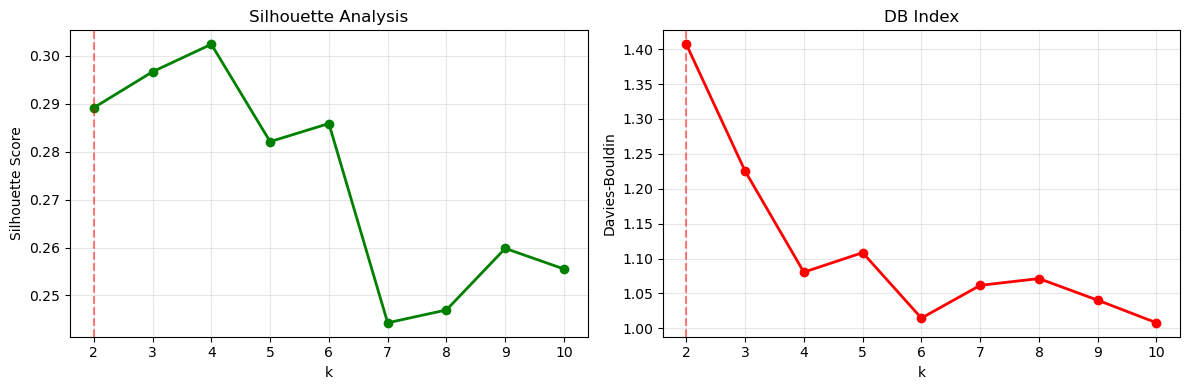


Best k = 4 (Silhouette: 0.302)
Let's use k=4 for now, can refine later


In [8]:
# quick plot
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# silhouette (higher is better)
ax[0].plot(k_values, silhouettes, 'go-', linewidth=2)
ax[0].set_xlabel('k')
ax[0].set_ylabel('Silhouette Score')
ax[0].set_title('Silhouette Analysis')
ax[0].grid(True, alpha=0.3)
ax[0].axvline(x=2, color='red', linestyle='--', alpha=0.5)

# davies-bouldin (lower is better)
ax[1].plot(k_values, db_scores, 'ro-', linewidth=2)
ax[1].set_xlabel('k')
ax[1].set_ylabel('Davies-Bouldin')
ax[1].set_title('DB Index')
ax[1].grid(True, alpha=0.3)
ax[1].axvline(x=2, color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# find best
best_k = k_values[silhouettes.index(max(silhouettes))]
print(f"\nBest k = {best_k} (Silhouette: {max(silhouettes):.3f})")
print("Let's use k=4 for now, can refine later")

## Train model with k=bestK

In [9]:
# Train K-Means with k=best
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
df_feat['cluster'] = kmeans.fit_predict(X)

print(f"k={best_k}")
print(f"Cluster assignments shape: {df_feat['cluster'].shape}")
print(f"\nCluster distribution:")
print(df_feat['cluster'].value_counts().sort_index())

df_feat.head()

k=4
Cluster assignments shape: (2895,)

Cluster distribution:
cluster
0     265
1     385
2     996
3    1249
Name: count, dtype: int64


,Date,ret_btc,vol_btc_7,fg_norm,cluster
0,2018-02-01,-0.108458,1.145908,0.30,0
1,2018-02-02,-0.037756,1.132089,0.15,0
2,2018-02-03,0.038233,1.180306,0.40,1
3,2018-02-04,-0.102991,1.149832,0.24,0
4,2018-02-05,-0.173982,1.447588,0.11,0


## Check quality

In [ ]:
# calculate metrics
sil = silhouette_score(X, df_feat['cluster'])
db = davies_bouldin_score(X, df_feat['cluster'])
ch = calinski_harabasz_score(X, df_feat['cluster'])

print(f"Silhouette Score: {sil:.3f} (higher is better)")
print(f"Davies-Bouldin: {db:.3f} (lower is better)")
print(f"Calinski-Harabasz: {ch:.1f} (higher is better)")


print("\n bc sil > 0.25  Looks decent, clusters are separable")

Silhouette Score: 0.302 (higher is better)
Davies-Bouldin: 1.081 (lower is better)
Calinski-Harabasz: 1001.4 (higher is better)

Looks decent, clusters are separable


In [11]:
# what does each cluster look like
cluster_stats = df_feat.groupby('cluster')[['ret_btc', 'vol_btc_7', 'fg_norm']].mean()
print("Average features per cluster:")
print(cluster_stats.round(4))

# about which one is fear, which is greed
# lower fg_norm = fear, higher = greed
cluster_stats

Average features per cluster:
         ret_btc  vol_btc_7  fg_norm
cluster                             
0        -0.0567     0.9948   0.3706
1         0.0404     0.9310   0.3143
2         0.0037     0.4939   0.7063
3        -0.0016     0.3880   0.3532


,ret_btc,vol_btc_7,fg_norm
cluster,,,
0,-0.056713,0.994837,0.370642
1,0.040366,0.931004,0.314260
2,0.003702,0.493949,0.706345
3,-0.001608,0.387982,0.353235


## Visualize regimes

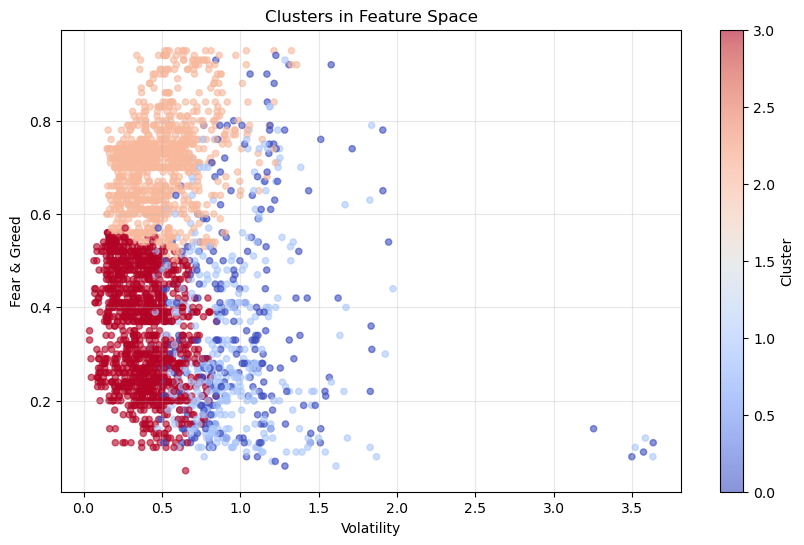

In [12]:
# scatter plot in feature space
plt.figure(figsize=(10, 6))
plt.scatter(df_feat['vol_btc_7'], df_feat['fg_norm'], 
           c=df_feat['cluster'], cmap='coolwarm', s=20, alpha=0.6)
plt.xlabel("Volatility")
plt.ylabel("Fear & Greed")
plt.title("Clusters in Feature Space")
plt.colorbar(label='Cluster')
plt.grid(True, alpha=0.3)
plt.show()

The two clusters are pretty clear - red cluster has lower sentiment (fear), blue has higher (greed)

## Timeline view

In [13]:
df_feat

,Date,ret_btc,vol_btc_7,fg_norm,cluster
0,2018-02-01,-0.108458,1.145908,0.30,0
1,2018-02-02,-0.037756,1.132089,0.15,0
2,2018-02-03,0.038233,1.180306,0.40,1
3,2018-02-04,-0.102991,1.149832,0.24,0
4,2018-02-05,-0.173982,1.447588,0.11,0
...,...,...,...,...,...
2890,2025-12-31,-0.010473,0.163933,0.21,3
2891,2026-01-01,0.013881,0.186970,0.20,3
2892,2026-01-02,0.013575,0.202279,0.28,3
2893,2026-01-03,0.007294,0.203287,0.29,3


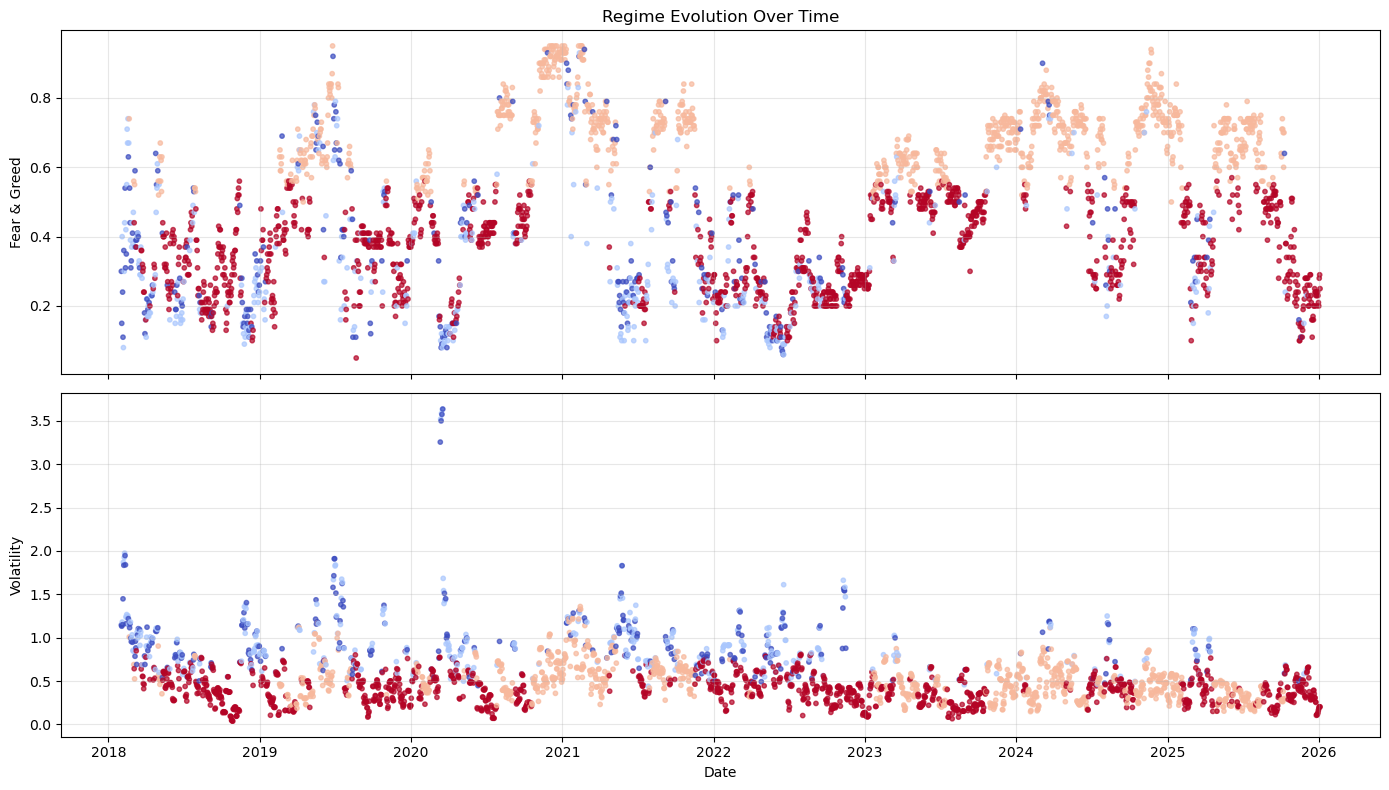

In [14]:
# plot over time
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# fear & greed over time
ax1.scatter(df_feat['Date'], df_feat['fg_norm'], 
           c=df_feat['cluster'], cmap='coolwarm', s=10, alpha=0.7)
ax1.set_ylabel('Fear & Greed')
ax1.set_title('Regime Evolution Over Time')
ax1.grid(True, alpha=0.3)

# volatility over time
ax2.scatter(df_feat['Date'], df_feat['vol_btc_7'], 
           c=df_feat['cluster'], cmap='coolwarm', s=10, alpha=0.7)
ax2.set_ylabel('Volatility')
ax2.set_xlabel('Date')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [15]:
print("Can see regime switching - red = fear, blue = greed, orange = neutral")

Can see regime switching - red = fear, blue = greed, orange = neutral


## Cluster Interpretation & Labeling

based on the feature means, we can interpret the two clusters as:

In [16]:
# detailed stats per cluster
cluster_full_stats = df_feat.groupby('cluster').agg({
    'ret_btc': ['mean', 'std'],
    'vol_btc_7': ['mean', 'std'],
    'fg_norm': ['mean', 'std']
}).round(4)

cluster_full_stats['count'] = df_feat.groupby('cluster').size()
cluster_full_stats = cluster_full_stats.sort_values(('fg_norm', 'mean'))  # from low to high

print("=" * 70)
print("Detailed Cluster Statistics (sorted by Fear&Greed)")
print("=" * 70)
print(cluster_full_stats)
print("\n" + "=" * 70)

# 自动贴标签（基于 fg_norm 和 vol_btc_7）
def label_cluster(row):
    fg = row[('fg_norm', 'mean')]
    vol = row[('vol_btc_7', 'mean')]
    
    if fg < 0.35:
        return "Fearful" if vol > 1.2 else "Anxious"
    elif fg < 0.5:
        return "Cautious Bearish"
    elif fg < 0.65:
        return "neutral"
    elif fg < 0.75:
        return "Optimistic Bullish"
    else:
        return "Overconfident"

cluster_labels = cluster_full_stats.apply(label_cluster, axis=1)
print("\nExplanation:")
for idx, label in cluster_labels.items():
    count_val = int(cluster_full_stats.loc[idx, 'count'])
    fg_mean = float(cluster_full_stats.loc[idx, ('fg_norm', 'mean')])
    vol_mean = float(cluster_full_stats.loc[idx, ('vol_btc_7', 'mean')])
    print(f"  Cluster {idx}: {label:12s} | Days: {count_val:4d} | AvgEmo: {fg_mean:.3f} | AvgVol: {vol_mean:.3f}")

Detailed Cluster Statistics (sorted by Fear&Greed)
        ret_btc         vol_btc_7         fg_norm         count
           mean     std      mean     std    mean     std      
cluster                                                        
1        0.0404  0.0336    0.9310  0.3614  0.3143  0.1795   385
3       -0.0016  0.0170    0.3880  0.1619  0.3532  0.1188  1249
0       -0.0567  0.0409    0.9948  0.4250  0.3706  0.2117   265
2        0.0037  0.0238    0.4939  0.2064  0.7063  0.1000   996


Explanation:
  Cluster 1: Anxious      | Days:  385 | AvgEmo: 0.314 | AvgVol: 0.931
  Cluster 3: Cautious Bearish | Days: 1249 | AvgEmo: 0.353 | AvgVol: 0.388
  Cluster 0: Cautious Bearish | Days:  265 | AvgEmo: 0.371 | AvgVol: 0.995
  Cluster 2: Optimistic Bullish | Days:  996 | AvgEmo: 0.706 | AvgVol: 0.494


/var/folders/tm/2mpx1bkj39x81n32__pl6vbw0000gn/T/ipykernel_666/3864243904.py:36: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  count_val = int(cluster_full_stats.loc[idx, 'count'])


## Feasibility Study Conclusion

According to the above analysis, clustering with simple features seems to be feasible for market fear regime identification.